In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import sqrt
from analysis import run_h1_pricing_experiment
from visualization import plot_error_box, plot_h3_graphs, gr_for_h2
from analysis import run_abm_paths, estimate_sigma
from model import ABMModel 
from utils import *
plt.style.use('seaborn-v0_8-darkgrid')


cfg = dict(
    S0=100.0,
    dt=1/252,
    steps=252,
    n_fund=50,
    n_noise=50,
    n_chart=50,
    n_mm=4,
    fundamental_price=100.0,
    tick_size=0.1,
    impact=0.07,
    omega=1e-6,
    alpha_var=0.05,
    beta_var=0.94,
    fund_strength=0.1,
    chart_strength=0.6,
    chart_vol_sens=2.0,
    mom_window=20,
    vol_window=20,
    agent_noise=0.15,
    p01=0.02,
    p10=0.10,
    shock_rate=0.01,
    shock_impact=8.0,
    n_events_calm=400,
    n_events_stress=1200,
)

dt = cfg["dt"]
steps = cfg["steps"]
r = 0.0
K_grid = [70, 80, 90, 95, 100]

df_bias, _, _ = run_h1_pricing_experiment(
    cfg=cfg,
    dt=dt,
    steps=steps,
    r=r,
    K_grid=K_grid,
    option_type="put",
    alpha_frac=0.5,
    n_paths=200,
    n_mc=40000,
    n_rep=10,
    seed0=0
)

t=200  bb=90.80000000000001  ba=91.10000000000001  sp=0.29999999999999716  db=59.0  da=8.0  trades_step=1
t=200  bb=99.60000000000001  ba=100.0  sp=0.3999999999999915  db=57.0  da=60.0  trades_step=0
t=200  bb=98.9  ba=99.30000000000001  sp=0.4000000000000057  db=59.0  da=57.0  trades_step=1
t=200  bb=89.80000000000001  ba=90.10000000000001  sp=0.29999999999999716  db=59.0  da=4.0  trades_step=1
t=200  bb=96.7  ba=97.0  sp=0.29999999999999716  db=26.0  da=1.0  trades_step=1
t=200  bb=90.30000000000001  ba=90.60000000000001  sp=0.29999999999999716  db=9.0  da=14.0  trades_step=23
t=200  bb=92.30000000000001  ba=92.7  sp=0.3999999999999915  db=41.0  da=42.0  trades_step=4
t=200  bb=100.60000000000001  ba=101.0  sp=0.3999999999999915  db=51.0  da=59.0  trades_step=1
t=200  bb=97.10000000000001  ba=97.80000000000001  sp=0.7000000000000028  db=4.0  da=5.0  trades_step=17
t=200  bb=103.30000000000001  ba=104.0  sp=0.6999999999999886  db=27.0  da=1.0  trades_step=1
t=200  bb=117.7  ba=118.100

## Hypothesis 2: BS is systematically biased relative to the reference, TFBS is closer to 0
H0: TFBS-bias = BS-bias (no improvement)

H1: |TFBS-bias| < |BS-bias| (TFBS is less biased → hypothesis F is true)

In [4]:
from scipy.stats import ttest_1samp, ttest_rel, wilcoxon


df_bias["signed_err_bs"] = df_bias["bs"] - df_bias["ref"]
df_bias["signed_err_frac"] = df_bias["frac"] - df_bias["ref"]

overall_bias_bs = df_bias["signed_err_bs"].mean()
overall_bias_frac = df_bias["signed_err_frac"].mean()

abs_bias_bs = np.abs(df_bias["signed_err_bs"]).mean()
abs_bias_frac = np.abs(df_bias["signed_err_frac"]).mean()

t_bs, p_bs = ttest_1samp(df_bias["signed_err_bs"], 0.0)
t_frac, p_frac = ttest_1samp(df_bias["signed_err_frac"], 0.0)

bias_by_K = (
    df_bias
    .groupby("K")[["signed_err_bs", "signed_err_frac"]]
    .mean()
    .rename(columns={"signed_err_bs": "bias_bs", "signed_err_frac": "bias_frac"})
    .reset_index()
)

print("\n=== Hypothesis F: pricing bias vs reference ===")
print(f"Overall BS bias:   {overall_bias_bs:.6f}  (abs={abs_bias_bs:.6f}, t={t_bs:.3f}, p={p_bs:.3g})")
print(f"Overall TFBS bias: {overall_bias_frac:.6f}  (abs={abs_bias_frac:.6f}, t={t_frac:.3f}, p={p_frac:.3g})")

print()

t_pair, p_pair = ttest_rel(df_bias["signed_err_bs"], df_bias["signed_err_frac"])
t_abs, p_abs = ttest_rel(
    np.abs(df_bias["signed_err_bs"]),
    np.abs(df_bias["signed_err_frac"])
)
w_stat, w_p = wilcoxon(
    np.abs(df_bias["signed_err_bs"]),
    np.abs(df_bias["signed_err_frac"])
)
print(f"Paired t-test: t={t_pair:.4f}, p={p_pair:.4g}")
print(f"Paired abs-bias t-test: t={t_abs:.4f}, p={p_abs:.4g}")
print(f"Wilcoxon test (abs bias): stat={w_stat}, p={w_p:.4g}")



=== Hypothesis F: pricing bias vs reference ===
Overall BS bias:   -0.431372  (abs=0.431372, t=-8.111, p=1.29e-10)
Overall TFBS bias: -0.195052  (abs=0.212846, t=-6.177, p=1.25e-07)

Paired t-test: t=-9.3098, p=2.046e-12
Paired abs-bias t-test: t=8.0987, p=1.35e-10
Wilcoxon test (abs bias): stat=90.0, p=3.706e-09


We can conclude that bias exists in both the BS and TFBS models, as the p-values ​​are very small (especially for the BS).

The BS model significantly underprices put options (average bias ≈ -0.42, highly significant).
TFBS also produces a negative bias, but approximately half as large in magnitude (≈ -0.18).
The main underpricing occurs around strike prices of 90–100, and there the TFBS model consistently reduces its bias,
remaining significantly closer to the ABM reference than the classic BS model.

All three tests (paired t-test, absolute bias t-test, and Wilcoxon) yielded extremely small p-values,
therefore we confidently reject the null hypothesis of equal bias for the BS and TFBS models.

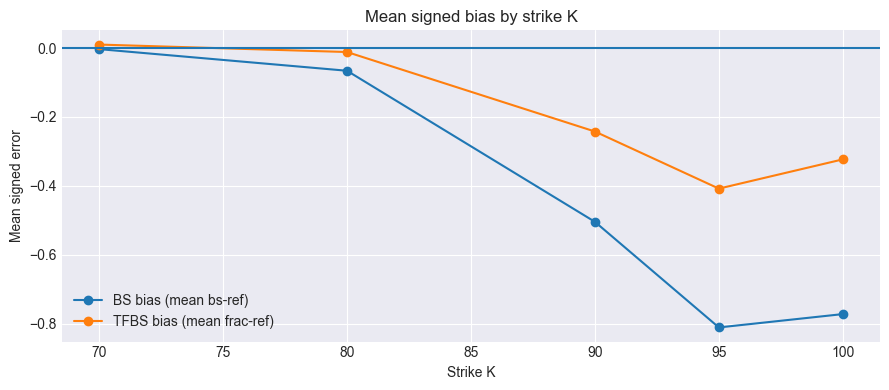

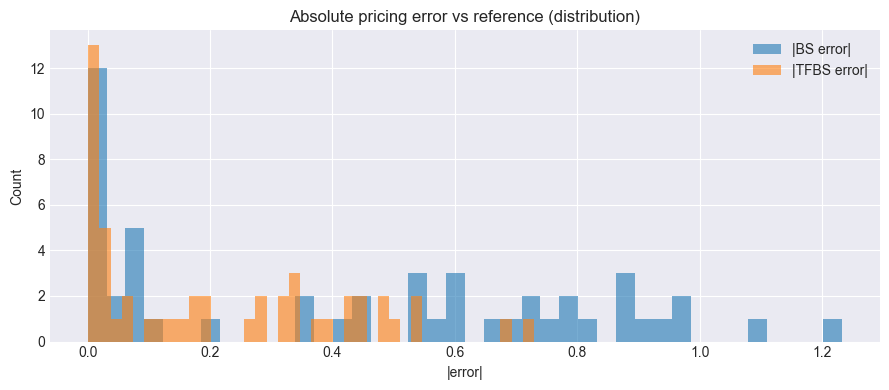

In [5]:
gr_for_h2(df_bias)

## Hypothesis 3: TFBS gains are largest for longer maturities and extreme strikes

In [7]:
from analysis import sample_positive_stable, simulate_frac_and_bs_payoffs, simulate_frac_and_bs_payoffs_call, simulate_frac_and_bs_payoffs_put, fractional_price_call_mc_cv, fractional_price_put_mc_cv

In [8]:
def run_h3_tfbs_gains_surface(
    cfg_base,
    steps_grid,
    moneyness_grid,
    r,
    alpha_frac,
    n_paths,
    n_mc,
    n_rep,
    seed0,
    option_type="put",
):
    rows = []
    S0 = float(cfg_base["S0"])
    dt = float(cfg_base["dt"])

    for rep in range(int(n_rep)):
        rep_seed = int(seed0 + rep * 999)

        for steps in steps_grid:
            steps = int(steps)
            cfg = dict(cfg_base)
            cfg["steps"] = steps

            paths = run_abm_paths(cfg, n_paths=int(n_paths), seed0=rep_seed)
            sigma = float(estimate_sigma(paths, dt=dt))
            T = float(steps) * dt

            for m in moneyness_grid:
                m = float(m)
                K = float(S0 * m)

                if option_type == "call":
                    ref = float(reference_price_call(paths, K=K, r=r, T=T))
                    p_bs = float(bs_price_call(S0, K, r, sigma, T))
                    p_fr = float(
                        fractional_price_call_mc_cv(
                            S0, K, r, sigma, T,
                            alpha=alpha_frac,
                            n_mc=n_mc,
                            seed=rep_seed + int(1e6 * m) + steps,
                        )
                    )
                else:
                    ref = float(reference_price_put(paths, K=K, r=r, T=T))
                    p_bs = float(bs_price_put(S0, K, r, sigma, T))
                    p_fr = float(
                        fractional_price_put_mc_cv(
                            S0, K, r, sigma, T,
                            alpha=alpha_frac,
                            n_mc=n_mc,
                            seed=rep_seed + int(1e6 * m) + steps,
                        )
                    )

                e_bs = abs(p_bs - ref)
                e_fr = abs(p_fr - ref)
                imp = float(e_bs - e_fr)

                rows.append({
                    "rep": int(rep),
                    "steps": int(steps),
                    "T": float(T),
                    "m": float(m),
                    "abs_log_m": float(abs(np.log(m))),
                    "K": float(K),
                    "sigma": float(sigma),
                    "ref": float(ref),
                    "bs": float(p_bs),
                    "frac": float(p_fr),
                    "abs_err_bs": float(e_bs),
                    "abs_err_frac": float(e_fr),
                    "improvement": float(imp),
                })

    return pd.DataFrame(rows)


def summarize_h3_tfbs(df, n_T_bins=4, n_m_bins=6):
    d = df.copy()
    d["T_bin"] = pd.qcut(d["T"], q=int(n_T_bins), duplicates="drop")
    d["m_bin"] = pd.qcut(d["abs_log_m"], q=int(n_m_bins), duplicates="drop")

    surf = (
        d.groupby(["T_bin", "m_bin"])["improvement"]
        .agg(["mean", "median", "count", lambda x: float(np.mean(np.array(x) > 0.0))])
        .reset_index()
    )
    surf = surf.rename(columns={"<lambda_0>": "share_improvement_pos"})

    byT = d.groupby("T")["improvement"].agg(["mean", "median", "count"]).reset_index()
    byM = d.groupby("abs_log_m")["improvement"].agg(["mean", "median", "count"]).reset_index()

    top = d.sort_values("improvement", ascending=False).head(15)[["rep", "T", "m", "K", "improvement", "abs_err_bs", "abs_err_frac"]]
    bot = d.sort_values("improvement", ascending=True).head(15)[["rep", "T", "m", "K", "improvement", "abs_err_bs", "abs_err_frac"]]

    return surf, byT, byM, top, bot

def h3_regression_simple(df):
    X = np.column_stack([
        np.ones(len(df)),
        df["abs_log_m"].values,
        df["T"].values,
        (df["abs_log_m"].values * df["T"].values),
    ])
    y = df["improvement"].values
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    s2 = float((resid @ resid) / max(1, n - k))
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(s2 * XtX_inv))

    out = {
        "beta_intercept": float(beta[0]),
        "beta_abs_log_m": float(beta[1]),
        "beta_T": float(beta[2]),
        "beta_interaction_abs_log_m_x_T": float(beta[3]),
        "se_intercept": float(se[0]),
        "se_abs_log_m": float(se[1]),
        "se_T": float(se[2]),
        "se_interaction": float(se[3]),
    }
    return out


In [ ]:
steps_grid = [126, 252, 504, 756]
moneyness_grid = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

df_h3 = run_h3_tfbs_gains_surface(
    cfg_base=cfg,
    steps_grid=steps_grid,
    moneyness_grid=moneyness_grid,
    r=0.0,
    alpha_frac=0.85,
    n_paths=80,
    n_mc=4000,
    n_rep=5,
    seed0=123,
    option_type="put",
)

surf, byT, byM, top, bot = summarize_h3_tfbs(df_h3, n_T_bins=4, n_m_bins=6)
reg = h3_regression_simple(df_h3)

t=200  bb=112.80  ba=113.10  sp=0.300  db=14.00  da=9.00  trades_step=27
t=200  bb=98.90  ba=99.20  sp=0.300  db=13.00  da=45.00  trades_step=2
t=200  bb=110.20  ba=110.30  sp=0.100  db=15.00  da=1.00  trades_step=25
t=200  bb=97.00  ba=97.40  sp=0.400  db=57.00  da=63.00  trades_step=1
t=200  bb=90.80  ba=91.20  sp=0.400  db=60.00  da=59.00  trades_step=0
t=200  bb=106.70  ba=106.90  sp=0.200  db=15.00  da=2.00  trades_step=30
t=200  bb=83.90  ba=84.10  sp=0.200  db=4.00  da=15.00  trades_step=31
t=200  bb=97.30  ba=97.60  sp=0.300  db=13.00  da=21.00  trades_step=23
t=200  bb=106.30  ba=106.60  sp=0.300  db=15.00  da=44.00  trades_step=23
t=200  bb=102.60  ba=103.30  sp=0.700  db=7.00  da=5.00  trades_step=14
t=200  bb=92.90  ba=93.10  sp=0.200  db=1.00  da=52.00  trades_step=0
t=200  bb=107.40  ba=107.80  sp=0.400  db=60.00  da=59.00  trades_step=1
t=200  bb=99.10  ba=99.90  sp=0.800  db=6.00  da=21.00  trades_step=13
t=200  bb=91.00  ba=91.40  sp=0.400  db=61.00  da=57.00  trades_s

/var/folders/5j/cxq1m23j1k77h961fvg0f3v00000gn/T/ipykernel_1589/2367395696.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby(["T_bin", "m_bin"])["improvement"]


In [ ]:
def h3_run_tests(df_h3, surf=None, B=5000, seed=1, q_long=0.75, q_far=0.75):
    d = df_h3.copy()
    needed = {"rep", "T", "abs_log_m", "improvement"}
    miss = needed - set(d.columns)
    if miss:
        raise ValueError(f"df_h3 missing columns: {miss}")

    d["win"] = (d["improvement"].values > 0.0).astype(int)

    betas = _cluster_bootstrap_reps(d, B=B, seed=seed)
    boot = {}
    names = ["beta_intercept", "beta_abs_log_m", "beta_T", "beta_interaction"]
    for j, nm in enumerate(names):
        mean, ci, p1 = _summ_ci_p(betas[:, j])
        boot[nm] = {"mean": mean, "ci95": ci, "p_one_sided_gt0": p1}

    T_thr = float(d["T"].quantile(q_long))
    m_thr = float(d["abs_log_m"].quantile(q_far))
    is_long = d["T"].values >= T_thr
    is_far = d["abs_log_m"].values >= m_thr

    A = d[is_long & is_far]
    Bdf = d[~(is_long & is_far)]

    posA, nA = int(A["win"].sum()), int(len(A))
    posB, nB = int(Bdf["win"].sum()), int(len(Bdf))
    pA, pB, z, p_one = _two_prop_ztest(posA, nA, posB, nB)

    group_test = {
        "T_thr_q": q_long,
        "abs_log_m_thr_q": q_far,
        "T_thr": T_thr,
        "abs_log_m_thr": m_thr,
        "Long&Far": {"pos": posA, "n": nA, "share": pA},
        "Other": {"pos": posB, "n": nB, "share": pB},
        "z_one_sided": z,
        "p_value_one_sided_pA_gt_pB": p_one,
    }

    trend = None
    if surf is not None:
        aggTbin, Z, p_tr = _trend_test_Tbin_from_surf(surf)
        trend = {"by_T_bin": aggTbin, "Z": Z, "p_one_sided_increasing": p_tr}

    overall_pretty = _format_overall(d)

    return {
        "overall_pretty": overall_pretty,
        "bootstrap_ols_by_rep": boot,
        "longfar_vs_other": group_test,
        "trend_Tbin_from_surf": trend,
    }

res = h3_run_tests(df_h3, surf=surf, B=5000, seed=1)


In [ ]:
print("\n=== H3 tests: overall ===")
print(res["overall_pretty"])


=== H3 tests: overall ===
TFBS wins (improvement>0): 96/140 = 68.6%  (loses: 44/140 = 31.4%)
Mean improvement: +0.020280   |   Median improvement: +0.011435
Replicates: 5   |   Total points: 140
Sign test vs 50% wins (one-sided): z=4.395, p=5.54369e-06


In [ ]:
print("\n=== H3 tests: cluster bootstrap OLS by rep (one-sided H1: coef > 0) ===")
for k, v in res["bootstrap_ols_by_rep"].items():
    ci = v["ci95"]
    print(f"{k:>18}: mean={v['mean']:+.6f}, CI95=({ci[0]:+.6f},{ci[1]:+.6f}), p_one_sided_gt0={v['p_one_sided_gt0']:.6f}")


=== H3 tests: cluster bootstrap OLS by rep (one-sided H1: coef > 0) ===
    beta_intercept: mean=-0.039167, CI95=(-0.124640,+0.047590), p_one_sided_gt0=0.850600
    beta_abs_log_m: mean=+0.103959, CI95=(-0.212273,+0.434814), p_one_sided_gt0=0.270400
            beta_T: mean=+0.037613, CI95=(+0.006079,+0.064441), p_one_sided_gt0=0.005600
  beta_interaction: mean=-0.069492, CI95=(-0.202820,+0.053663), p_one_sided_gt0=0.850600


Increasing the term T significantly increases improvement. This confirms part H3, which states that the effect is stronger for larger T.

In [ ]:
if res["trend_Tbin_from_surf"] is not None:
    tr = res["trend_Tbin_from_surf"]
    print("\n=== H3 tests: trend in win-share across T_bin (Cochran–Armitage, one-sided increasing) ===")
    print(tr["by_T_bin"].to_string(index=False))
    print(f"Z={tr['Z']:.4f}, p(one-sided)={tr['p_one_sided_increasing']:.6f}")


=== H3 tests: trend in win-share across T_bin (Cochran–Armitage, one-sided increasing) ===
         T_bin  pos  count  T_mid
(0.499, 0.875]   15     35 0.6870
  (0.875, 1.5]   22     35 1.1875
   (1.5, 2.25]   30     35 1.8750
   (2.25, 3.0]   29     35 2.6250
Z=4.0709, p(one-sided)=0.000023


The probability that TFBS is better than BS increases significantly with T (monotonic trend). This is a direct and very strong confirmation of H3 based on maturity.

H3 is confirmed in the part “longer term → TFBS helps more often and stronger” (trend p=2.3e-05 and beta_T>0 with bootstrap-CI above 0). \
The part “extreme strikes increase the effect on large T” is not proven by this data

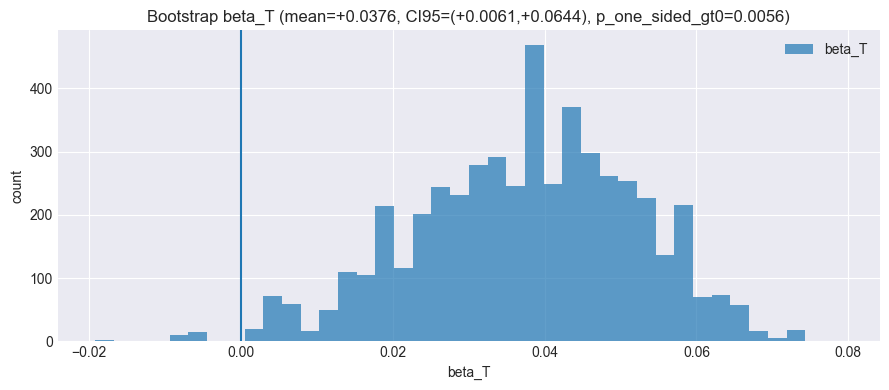

In [ ]:
plot_h3_graphs(df_h3=df_h3, surf=surf, res=res, B=5000, seed=1)